## akshataupadhye/finetuning-sentiment-model-reddit-data

Anche il secondo modello che andrò a testare è disponibile su <a href="https://huggingface.co/akshataupadhye/finetuning-sentiment-model-reddit-data">Hugging Face</a>.
Questo modello si basa su distilbert-base-uncased.


# Dataset

In [1]:
!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
from datasets import Dataset, load_dataset, ClassLabel, Value, Features, DatasetDict
from transformers import AutoTokenizer
import pandas as pd
import torch

class RedditDataset:
  """
    La classe RedditDataset si occupa di rappresentare il dataset che viene usato per l'addestramento, occupandosi anche della divisione tra Train, Test e Validation
  """

  def __init__(self, csv_file, scale = False):
    """
      Costruttore della classe, che si occupa di caricare il file indicato dal parametro csv_file.
      Inoltre divide il dataset in Train (80%), Test (10%) e Validation (10%).

    PARAMETRI:
      csv_file: percorso del file csv da caricare
      scale: se True aumenta di uno le label del dataset (default False)
    """
    data = pd.read_csv(csv_file, on_bad_lines='skip')
    data.dropna(inplace=True)

    if len(data) == 0:
      raise ValueError("Dataset vuoto")

    if scale:
      data["category"] = data["category"] + 1

    unique_labels = [str(label) for label in sorted(data["category"].dropna().unique())]

    features = Features({
      'clean_comment': Value('string'),
      'category': ClassLabel(names=unique_labels)
    })

    train_ds = Dataset.from_pandas(data, features=features, preserve_index=False)
    ddict  = train_ds.train_test_split(test_size=0.2, seed=42, stratify_by_column="category")
    validations = ddict["test"].train_test_split(test_size=0.5, seed=42)

    self.dataset = DatasetDict({
      'train': ddict["train"],
      'validation': validations["train"],
      'test': validations["test"]
    })

  def _tokenize(self, batch : dict, tokenizer : Tokenizer) -> dict:
    """
      Tokenizza una lista di commenti testuali usando il tokenizer fornito.

    PARAMETRI:
        batch (dict): Dizionario contenente la chiave 'clean_comment' con una lista di commenti da tokenizzare.
        tokenizer (Tokenizer): Un oggetto tokenizer compatibile che converte il testo in token.

    RITORNA:
        dict: Risultato della tokenizzazione
    """
    comments = batch['clean_comment']
    return tokenizer(comments, padding="max_length", truncation=True, max_length=128)

  def _cast_labels_to_int(self, batch : dict) -> dict:
    """
      Converte le etichette testuali/numeriche in interi long tensor per l'addestramento del modello.

    PARAMETRI:
        batch (dict): Dizionario contenente la chiave 'category' con le etichette grezze (stringhe o numeri).

    RITORNA:
        dict: Il batch aggiornato 
    """
    batch["labels"] = [int(label) for label in batch["category"]]
    batch["labels"] = torch.tensor(batch["labels"], dtype=torch.long)
    return batch

  def prepare_dataset(self, tokenizer : Tokenizer):
    """
      Operazioni che si vanno ad efetturare al dataset prima dell'addestramento.
      In particolare si vanno a creare i token e si castano le label in interi.

    PARAMETRI:
      tokenizer (Tokenizer): tokenizer da utilizzare
    """
    for split in self.dataset:

      self.dataset[split] = self.dataset[split].map(self._tokenize, batched=True, fn_kwargs={'tokenizer': tokenizer})
      self.dataset[split] = self.dataset[split].map(self._cast_labels_to_int, batched=True)

  def get_train_dataset(self) -> Dataset:
    """
      Restituisce il dataset di addestramento.
    
    RITORNA:
      Dataset (Dataset): Il dataset di addestramento.
    """
    return self.dataset["train"]

  def get_validation_dataset(self) -> Dataset:
    """
      Restituisce il dataset di validazione.

    RITORNA:
      Dataset (Dataset): Il dataset di validazione.
    """
    return self.dataset["validation"]

  def get_test_dataset(self) -> Dataset:
    """
      Restituisce il dataset di test.

    RITORNA:
      Dataset (Dataset): Il dataset di test.
    """
    return self.dataset["test"]

  def print(self):
    """
      Stampa il dataset, principalmente per scopo di debug
    """
    for split in self.dataset:
      print(f"{split} split: {self.dataset[split]}")


# Modello

Per rapperesentare il modello è stata usata la classe SentimentAnalysisModel

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch


class SentimentAnalysisModel:
  """
    Classe che si occupa di gestire il modello di Sentiment Analysis
    Si occupa di preparare il trainer, addestrare il modello e stampare i report.
  """

  def __init__(self):
    """
      Inizializza il modello di Sentiment Analysis, il tokenizer e il modello pre-addestrato.
      Il modello utilizzato è 'akshataupadhye/finetuning-sentiment-model-reddit-data'.
    """
    model_name = "akshataupadhye/finetuning-sentiment-model-reddit-data"
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, problem_type="single_label_classification")
    self.trainer = None

  def prepare_trainer(self, dataset_train : Dataset, dataset_eval : Dataset):
    """
      Prepara il trainer per l'addestramento del modello.
    
    PARAMETRI:
      dataset_train (Dataset): Il dataset di addestramento.
      dataset_eval (Dataset): Il dataset di valutazione.
    """
    training_args = TrainingArguments(
      output_dir="./results",
      report_to="none",
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      num_train_epochs=3,
      weight_decay=0.01,
      save_strategy="epoch",
    )
    self.trainer = Trainer(
        model=self.model,
        args=training_args,
        train_dataset=dataset_train,
        eval_dataset=dataset_eval,
        processing_class=self.tokenizer,
        compute_metrics=self._compute_metrics,
    )

  def get_tokenizer(self) -> Tokenizer:
    """
      Restituisce il tokenizer utilizzato dal modello.
    RITORNA:
      Tokenizer: Il tokenizer utilizzato per il modello.
    """
    return self.tokenizer

  def _compute_metrics(self, eval_pred) -> dict:
    """
      Calcola le metriche di valutazione per il modello, in particolare l'accurate
      e il F1 score.
    PARAMETRI:
        eval_pred: Le predizioni da valutare.
    RITORNA:
      dict: Un dizionario contenente le metriche calcolate.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

  def train(self):
    """
      Avvia l'addestramento del modello.
    """
    if self.trainer is None:
      raise ValueError("Trainer non inizializzato")
    self.trainer.train()

  def print_report(self, dataset_test : Dataset, is_pre_finetuning : bool = False, confusion_matrix_path : str = "/content/drive/MyDrive/confusion_matrix-finetuning-sentiment-model-reddit-data"):
    """
      Stampa il report delle prestazioni del modello sul dataset di test.
    PARAMETRI:
      dataset_test (Dataset): Il dataset di test su cui valutare il modello.
      is_pre_finetuning (bool): Indica se la valutazione è pre-addestramento (default False).
      confusion_matrix_path (str): Percorso dove salvare la matrice di confusione (default "/content/drive/MyDrive/confusion_matrix-twitter-roberta-base-sentiment").
    """
    if self.trainer is None:
      raise ValueError("Trainer non inizializzato")

    label_names = ["Negativo", "Neutrale", "Positivo"]

    predictions = self.trainer.predict(dataset_test)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    print(f"\nConfusion Matrix:\n{cm}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predetto")
    plt.ylabel("Reale")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{confusion_matrix_path}{'-prefinetuning' if is_pre_finetuning else '-finetuned'}.png")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))

    metrics = self.trainer.evaluate()
    print("\n Statistiche finali sul test set:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

  def save(self, model_save_path):
    """
      Salva il modello e il tokenizer nel percorso specificato.
    PARAMETRI:
      model_save_path (str): Il percorso dove salvare il modello e il tokenizer.
    """
    if self.trainer is None:
      raise ValueError("Trainer non inizializzato")

    self.trainer.save_model(model_save_path)
    self.tokenizer.save_pretrained(model_save_path)



# Addestramento

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/29719 [00:00<?, ? examples/s]

Map:   0%|          | 0/29719 [00:00<?, ? examples/s]

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Statistiche pre-fine tuning:



Confusion Matrix:
[[0.85505481 0.0499391  0.09500609]
 [0.02635659 0.93410853 0.03953488]
 [0.06234414 0.02493766 0.9127182 ]]


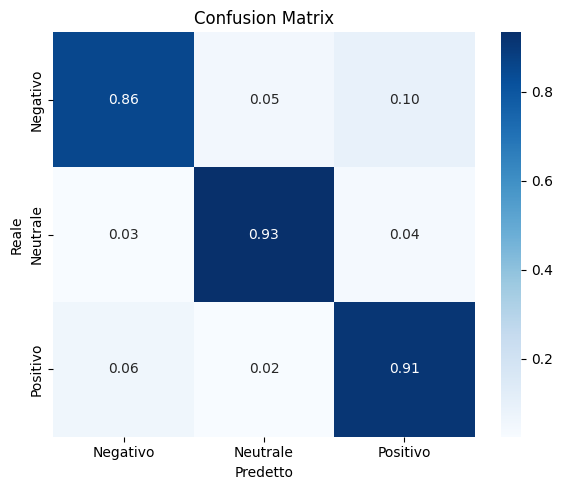


Classification Report:
              precision    recall  f1-score   support

    Negativo       0.84      0.86      0.85       821
    Neutrale       0.94      0.93      0.94      1290
    Positivo       0.92      0.91      0.92      1604

    accuracy                           0.91      3715
   macro avg       0.90      0.90      0.90      3715
weighted avg       0.91      0.91      0.91      3715




 Statistiche finali sul test set:
eval_loss: 0.3400
eval_model_preparation_time: 0.0016
eval_accuracy: 0.9074
eval_f1: 0.9076
eval_runtime: 14.2728
eval_samples_per_second: 260.2850
eval_steps_per_second: 32.5790
Inizio Addestramento


Step,Training Loss
500,0.438800
1000,0.412200
1500,0.352400
2000,0.321600
2500,0.305700
3000,0.296300
3500,0.276200
4000,0.237300
4500,0.181100
5000,0.168200


Fine Addestramento
Statistiche post-fine tuning:

Confusion Matrix:
[[0.92448234 0.01705238 0.05846529]
 [0.00465116 0.98527132 0.01007752]
 [0.03990025 0.00935162 0.95074813]]


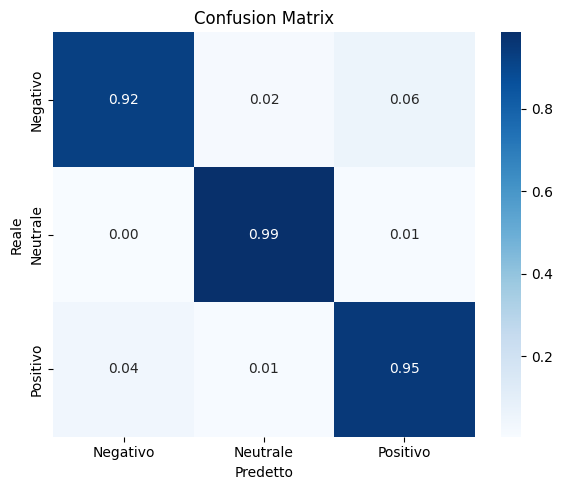


Classification Report:
              precision    recall  f1-score   support

    Negativo       0.92      0.92      0.92       821
    Neutrale       0.98      0.99      0.98      1290
    Positivo       0.96      0.95      0.96      1604

    accuracy                           0.96      3715
   macro avg       0.95      0.95      0.95      3715
weighted avg       0.96      0.96      0.96      3715




 Statistiche finali sul test set:
eval_loss: 0.2110
eval_model_preparation_time: 0.0016
eval_accuracy: 0.9569
eval_f1: 0.9569
eval_runtime: 14.2086
eval_samples_per_second: 261.4620
eval_steps_per_second: 32.7270
epoch: 3.0000
Statistiche di Test

Confusion Matrix:
[[0.90647482 0.0263789  0.06714628]
 [0.0090978  0.98256255 0.00833965]
 [0.04161332 0.00768246 0.95070423]]


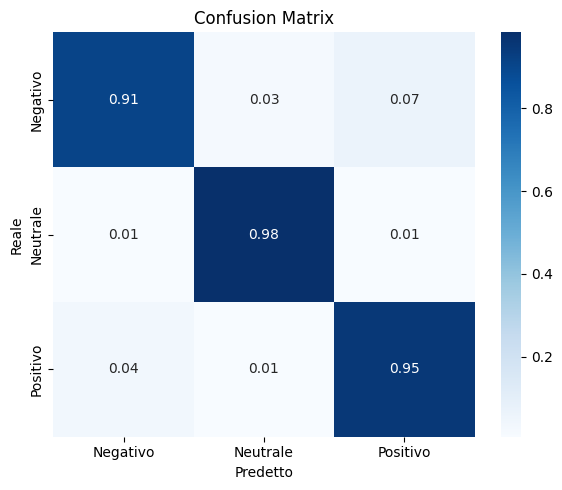


Classification Report:
              precision    recall  f1-score   support

    Negativo       0.91      0.91      0.91       834
    Neutrale       0.97      0.98      0.98      1319
    Positivo       0.96      0.95      0.95      1562

    accuracy                           0.95      3715
   macro avg       0.95      0.95      0.95      3715
weighted avg       0.95      0.95      0.95      3715




 Statistiche finali sul test set:
eval_loss: 0.2110
eval_model_preparation_time: 0.0016
eval_accuracy: 0.9569
eval_f1: 0.9569
eval_runtime: 13.7525
eval_samples_per_second: 270.1330
eval_steps_per_second: 33.8120
epoch: 3.0000


In [5]:
from google.colab import drive
drive.mount('/content/drive') #Per il salvataggio all'interno di Google Drive

reddit_dataset = None
try:
    reddit_dataset = RedditDataset("./Reddit_Data.csv", scale=True)
except FileNotFoundError:
    print("Non è stato possibile trovare il file contenente il Database")
except ValueError as e:
    print(e)

model = SentimentAnalysisModel()
reddit_dataset.prepare_dataset(model.get_tokenizer())

model.prepare_trainer(reddit_dataset.get_train_dataset(), reddit_dataset.get_validation_dataset())

print("Statistiche pre-fine tuning:")
model.print_report(reddit_dataset.get_validation_dataset(), is_pre_finetuning=True)

print("Inizio Addestramento")
model.train()
print("Fine Addestramento")

print("Statistiche post-fine tuning:")
model.print_report(reddit_dataset.get_validation_dataset())

print("Statistiche di Test")
model.print_report(reddit_dataset.get_test_dataset(), confusion_matrix_path="/content/drive/MyDrive/confusion_matrix-finetuning-sentiment-model-reddit-data-TEST")

model.save("/content/drive/MyDrive/finetuning-sentiment-model-reddit-data")